In [ ]:
from google.colab import drive
import pandas as pd
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
project_path = '/content/drive/MyDrive/ProgLab/Project/Data22_23/Latest/'

# Loading Dataset

In [ ]:
frequencies = pd.read_csv(project_path+'fr_dt_21-22.csv')
frequencies.head()

,datetime,frequency
0,2021-01-01 00:00,50.03
1,2021-01-01 00:15,50.03
2,2021-01-01 00:30,50.02
3,2021-01-01 00:45,50.01
4,2021-01-01 01:00,50.02


In [ ]:
def prepare_data(frequencies):
  frequencies['datetime'] = pd.to_datetime(frequencies['datetime'], format="%Y-%d-%m %H:%M")
  frequencies['period'] = 'night'

  # Update the 'daytime' column based on the specified time range
  frequencies.loc[(frequencies['datetime'].dt.time >= pd.to_datetime('06:00').time()) &
                  (frequencies['datetime'].dt.time <= pd.to_datetime('18:30').time()), 'period'] = 'day'

  one_hot_encoded_period = pd.get_dummies(frequencies['period'], prefix='period')


  frequencies['is_weekend'] = 'no'

  # Update the 'is_weekend' column based on the day of the week
  frequencies.loc[frequencies['datetime'].dt.dayofweek.isin([5, 6]), 'is_weekend'] = 'yes'

  one_hot_encoded_is_weekend = pd.get_dummies(frequencies['is_weekend'], prefix='is_weekend')

  # Concatenate the one-hot encoded columns to the original DataFrame
  frequencies = pd.concat([frequencies, one_hot_encoded_period, one_hot_encoded_is_weekend], axis=1)

  frequencies.drop(columns=['period', 'is_weekend'], inplace=True)

  return frequencies

frequencies = prepare_data(frequencies)

In [ ]:
# frequencies['datetime'] = pd.to_datetime(frequencies['datetime'], format="%Y-%d-%m %H:%M")
# frequencies['period'] = 'night'

# # Update the 'daytime' column based on the specified time range
# frequencies.loc[(frequencies['datetime'].dt.time >= pd.to_datetime('06:00').time()) &
#                 (frequencies['datetime'].dt.time <= pd.to_datetime('18:30').time()), 'period'] = 'day'

# # one_hot_encoded_period = pd.get_dummies(frequencies['period'], prefix='period')


# frequencies['is_weekend'] = 'no'

# # Update the 'is_weekend' column based on the day of the week
# frequencies.loc[frequencies['datetime'].dt.dayofweek.isin([5, 6]), 'is_weekend'] = 'yes'

# # one_hot_encoded_is_weekend = pd.get_dummies(frequencies['is_weekend'], prefix='is_weekend')

# # Concatenate the one-hot encoded columns to the original DataFrame
# # frequencies = pd.concat([frequencies, one_hot_encoded_period, one_hot_encoded_is_weekend], axis=1)

# # frequencies.drop(columns=['period', 'is_weekend'], inplace=True)
# frequencies.sample(n=6)

In [ ]:
train_data = frequencies[frequencies['datetime'].dt.year == 2021]
train_data = train_data[train_data['datetime'].dt.month < 7]
train_data.head()

,datetime,frequency,period_day,period_night,is_weekend_no,is_weekend_yes
0,2021-01-01 00:00:00,50.03,0,1,1,0
1,2021-01-01 00:15:00,50.03,0,1,1,0
2,2021-01-01 00:30:00,50.02,0,1,1,0
3,2021-01-01 00:45:00,50.01,0,1,1,0
4,2021-01-01 01:00:00,50.02,0,1,1,0


In [ ]:
# test_data = frequencies[frequencies['datetime'].dt.year == 2021]
# test_data = test_data[test_data['datetime'].dt.month == 7]
# # test_data = february_data[february_data['datetime'].dt.day < 8]
# test_data

test_data = pd.read_csv(project_path+'Test_jan23.csv')
test_data['datetime'] = pd.to_datetime(test_data['datetime'])
test = test_data
test_data

,datetime,frequency
0,2023-01-01 00:00:00,49.95
1,2023-01-01 00:15:00,49.88
2,2023-01-01 00:30:00,49.84
3,2023-01-01 00:45:00,49.99
4,2023-01-01 01:00:00,49.98
...,...,...
2971,2023-01-31 22:45:00,50.00
2972,2023-01-31 23:00:00,49.99
2973,2023-01-31 23:15:00,49.99
2974,2023-01-31 23:30:00,50.01


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

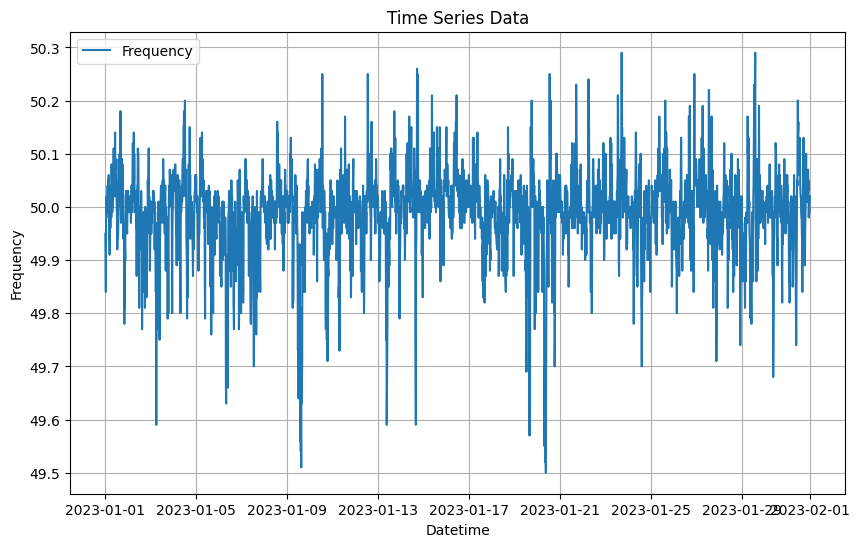

In [ ]:
# Plot the time series data
df = test_data
df['datetime'] = pd.to_datetime(df['datetime'])
plt.figure(figsize=(10, 6))
plt.plot(df['datetime'], df['frequency'], label='Frequency', linestyle='-')

# Customize the plot
plt.title('Time Series Data')
plt.xlabel('Datetime')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten, AveragePooling1D
from keras.callbacks import EarlyStopping
from keras_tuner.tuners import RandomSearch

In [ ]:
# Load your time series data
# Assuming you have a DataFrame named 'df' with 'frequency' and 'datetime' columns
# Make sure 'datetime' column is in datetime format
# You can convert it using: df['datetime'] = pd.to_datetime(df['datetime'])
# For this example, I assume 'datetime' is the index
df = train_data
df['datetime'] = pd.to_datetime(df['datetime'])
df.set_index('datetime', inplace=True)

In [ ]:
# Normalize the data using MinMaxScaler
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)


In [ ]:
def create_sequences(data, sequence_length):
    sequences, labels = [], []
    for i in range(len(data) - sequence_length):
        seq = data.iloc[i:i + sequence_length].values
        label = data.iloc[i + sequence_length].values
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels)


In [ ]:
# Define sequence length and create sequences
sequence_length = 5  # You can adjust this based on your data
X, y = create_sequences(df_scaled, sequence_length)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Reshape data for CNN input
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [ ]:
# Build the LSTM model with CNN layers
model = Sequential()
model.add(Conv1D(filters=4, kernel_size=4, activation='selu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(units=10, activation='selu'))
model.add(Dense(units=df.shape[1]))
model.compile(optimizer='adam', loss='mse')

# Define early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/50


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
694/695 [============================>.] - ETA: 0s - loss: 0.0755

Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
695/695 [==============================] - 16s 16ms/step - loss: 0.0754 - val_loss: 0.0204
Epoch 2/50
695/695 [==============================] - 8s 11ms/step - loss: 0.0181 - val_loss: 0.0170
Epoch 3/50
695/695 [==============================] - 7s 10ms/step - loss: 0.0167 - val_loss: 0.0164
Epoch 4/50
695/695 [==============================] - 4s 6ms/step - loss: 0.0162 - val_loss: 0.0161
Epoch 5/50
695/695 [==============================] - 3s 5ms/step - loss: 0.0159 - val_loss: 0.0156
Epoch 6/50
695/695 [==============================] - 4s 5ms/step - loss: 0.0156 - val_loss: 0.0155
Epoch 7/50
695/695 [==============================] - 5s 7ms/ste

In [ ]:
# Evaluate the model
loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")

# Make predictions
predictions = model.predict(X_test)

# Optionally, inverse transform the predictions and actual values to the original scale
predictions = scaler.inverse_transform(predictions)
y_test_orig = scaler.inverse_transform(y_test)

109/109 [==============================] - 0s 3ms/step - loss: 0.0108
Test Loss: 0.010778927244246006


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
109/109 [==============================] - 1s 3ms/step


In [ ]:
from sklearn.metrics import r2_score

# Calculate R-squared
r2 = r2_score(y_test_orig, predictions)
print(f"R-squared: {r2}")

R-squared: 0.8199996177163872


# UnSeen Test

In [ ]:
test_data = prepare_data(test)

In [ ]:
test_data['datetime'] = pd.to_datetime(test_data['datetime'])
datetime = list(test_data['datetime'])
test_data.set_index('datetime', inplace=True)

In [ ]:
# Normalize the data using MinMaxScaler
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(test_data), columns=test_data.columns)

In [ ]:
X, y = create_sequences(df_scaled, sequence_length)

In [ ]:
pred = model.predict(X)
pred = scaler.inverse_transform(pred)

93/93 [==============================] - 0s 3ms/step


(3475, 3475)


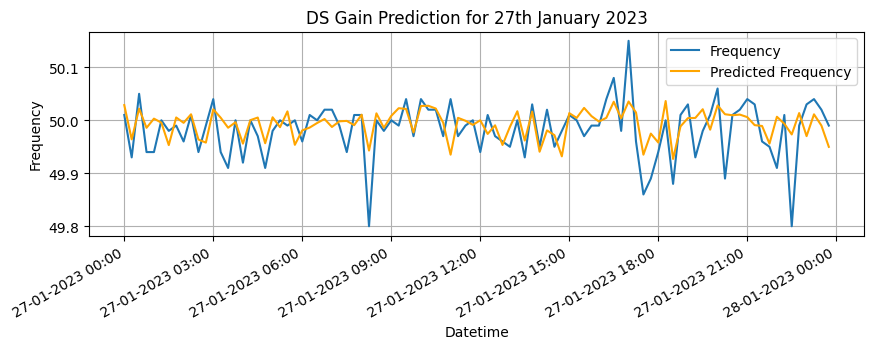

In [ ]:
import matplotlib.dates as mdates
# Plot the time series data
df = test_data
# Choose the index of the feature you want to plot
feature_index = df.columns.get_loc("frequency")
actual = y_test_orig[:, feature_index]
pred = predictions[:, feature_index]

start = 96*26
data_len = 96
print((len(actual), len(pred)))
fig = plt.figure(figsize=(10, 3))
plt.plot(datetime[start:start+data_len], actual[start:start+data_len], label='Frequency', linestyle='-')
plt.plot(datetime[start:start+data_len], pred[start:start+data_len], label='Predicted Frequency', linestyle='-', color='orange')
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y %H:%M'))
plt.gcf().autofmt_xdate()
# Customize the plot
plt.title('DS Gain Prediction for 27th January 2023')
plt.xlabel('Datetime')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.savefig('output_plot_day.jpg')
# Show the plot
plt.show()

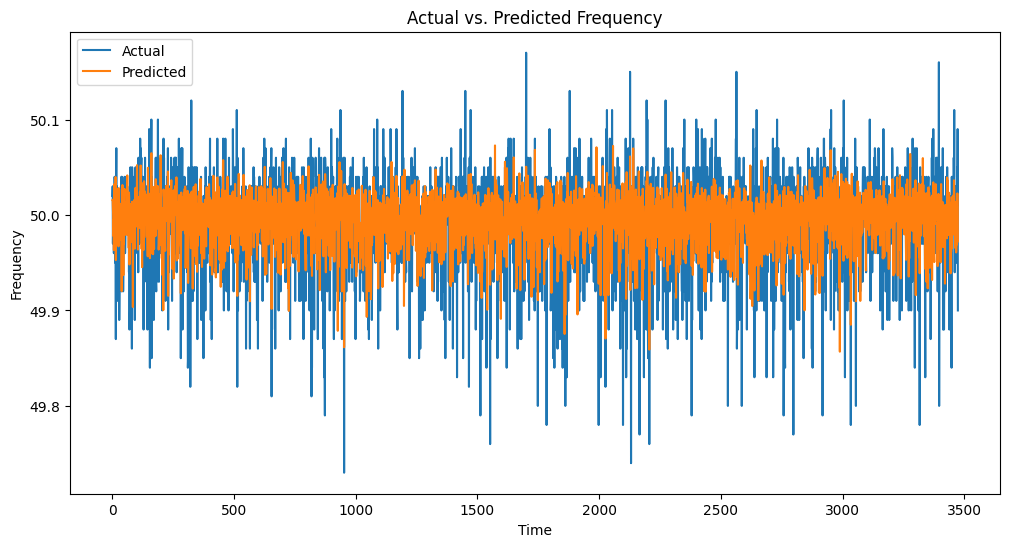

In [ ]:
import matplotlib.pyplot as plt

# Choose the index of the feature you want to plot
feature_index = df.columns.get_loc("frequency")

# Plot actual vs. predicted values
plt.figure(figsize=(12, 6))

actual_values = y_test_orig[:, feature_index]
predicted_values = predictions[:, feature_index]

plt.plot(actual_values, label='Actual')
plt.plot(predicted_values, label='Predicted')

plt.title('Actual vs. Predicted Frequency')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.legend()

plt.show()


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2, 4)              84        
                                                                 
 max_pooling1d (MaxPooling1  (None, 1, 4)              0         
 D)                                                              
                                                                 
 lstm (LSTM)                 (None, 10)                600       
                                                                 
 dense (Dense)               (None, 5)                 55        
                                                                 
Total params: 739 (2.89 KB)
Trainable params: 739 (2.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


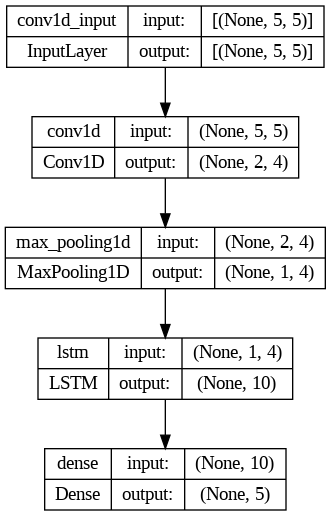

In [ ]:
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
# !pip install --upgrade tensorflow